In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

RCP_FOLDER = os.path.join(os.getcwd(), os.pardir)

In [2]:
def find_p_value(subm_mean, subm_stdev, subm_num_samples,
                ref_mean, ref_stdev, ref_num_samples,
                alpha=0.05):
    '''
    Do t-test between submission and reference and return p-value and
    whether it is larger than the limit
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    '''
    t_stat, p_value = scipy.stats.ttest_ind_from_stats(
                            subm_mean, subm_stdev, subm_num_samples,
                            ref_mean, ref_stdev, ref_num_samples,
                            equal_var=True)

    # convert from 2-sided test to 1-sided test
    if t_stat < 0:
        p_value = p_value / 2
    else:
        p_value = 1 - (p_value / 2)
    return p_value > alpha, p_value




def find_min_acceptable_mean(mean, stdev, num_samples_ref, tolerance = 0.0001, alpha = 0.05, n_runs = 10):
    '''
    Do a binary search to find the min acceptable epoch mean to converge
    The limits are 0 and the reference mean, anything above reference is acceptable
    '''

    if stdev == 0:
        return mean
    num_samples_subm = n_runs - 2
    mean_max = mean
    mean_min = 0.0
    mean_mid = (mean_min + mean_max) / 2
    while mean_max - mean_min > tolerance:
        # We assume similar stdev between submission and reference
        # Samples and means are different for p-value function
        _, p_value = find_p_value(
                            mean_mid, stdev, num_samples_ref,
                            mean, stdev, num_samples_subm,
                            alpha)
        if p_value > alpha:
            mean_max = mean_mid
        else:
            mean_min = mean_mid
        mean_mid = (mean_min + mean_max) / 2

    return mean_mid



def compute_rcp_stats(benchmark, epoch_list):
    submission_runs = {
        'bert': 10,
        'dlrm_dcnv2': 10,
        'gpt3': 3,
        'maskrcnn' : 5,
        'resnet' : 5,
        'ssd' : 5,
        'unet3d' : 40,
        'rnnt': 10,
        'stable_diffusion': 10,
        'gnn': 10,  
        'llama2_70b_lora': 10,
    }
    samples_rejected = 4 if benchmark == 'unet3d' else 1
    epoch_list.sort()
    stats = {}
    stats['RCP Median'] = float(np.median(epoch_list[samples_rejected:len(epoch_list)-samples_rejected]))
    stats['RCP Mean'] = float(np.mean(epoch_list[samples_rejected:len(epoch_list)-samples_rejected]))
    stats['RCP Stdev'] = float(np.std(epoch_list[samples_rejected:len(epoch_list)-samples_rejected]))
    min_epochs = find_min_acceptable_mean(
                       stats['RCP Mean'],
                       stats['RCP Stdev'],
                       len(epoch_list)-samples_rejected*2,
                        submission_runs[benchmark])
    stats['Max Speedup'] = stats['RCP Mean'] / min_epochs
    stats['Min Epochs'] = min_epochs
    return stats


source = f"{RCP_FOLDER}/training_4.1.0"
benchmarks = []
batch_sizes = []
mean_epochs = []
median_epochs = []
std_epochs = []
min_epochs = []
max_speed_up = []
for f in os.listdir(source):
    benchmark = f[5:-5].split(".")[0]
    benchmarks.append(benchmark)
    bs = []
    me = []
    mde = []
    ste = []
    mine = []
    mxsp = []
    with open(f"{source}/{f}") as file:
        j = json.load(file)
        for v in j.values():
            bs.append(v["BS"])
            conv_unit = "samples to converge" if benchmark =='llama2_70b_lora' else "Epochs to converge"
            stats = compute_rcp_stats(benchmark, v[conv_unit])
            me.append(stats["RCP Mean"])
            mde.append(stats["RCP Median"])
            ste.append(stats["RCP Stdev"])
            mine.append(stats["Min Epochs"])
            mxsp.append(stats["Max Speedup"])
        batch_sizes.append(bs)
        mean_epochs.append(me)
        median_epochs.append(mde)
        std_epochs.append(ste)
        min_epochs.append(mine)
        max_speed_up.append(mxsp)

print(benchmarks)
print(batch_sizes)
print(mean_epochs)
print(median_epochs)
print(std_epochs)
print(min_epochs)
print(max_speed_up)

print(len(benchmarks))
print(len(batch_sizes))
print(len(mean_epochs))
print(len(median_epochs))
print(len(std_epochs))
print(len(min_epochs))
print(len(max_speed_up))

['bert', 'llama2_70b_lora', 'ssd', 'stable_diffusion', 'gnn', 'dlrm_dcnv2', 'gpt3']
[[256, 448, 1536, 4096, 3072, 4608, 6144, 6912, 8192, 8704, 12288, 13056, 16384], [8, 16, 32, 128], [256, 320, 512, 768, 1024, 1280, 2048, 2560, 4096], [256, 384, 512, 1024, 2048], [4096, 16384, 32768, 65536, 262144], [32768, 55296, 65536, 102400, 135168], [1536, 2048, 3072, 4096, 6144, 8192]]
[[2549219.5555555555, 2414421.3333333335, 2776278.222222222, 2843989.3333333335, 2764498.6666666665, 2798080.0, 3319125.3333333335, 3601920.0, 4186112.0, 4273706.666666667, 4465066.666666667, 4645333.333333333, 5505422.222222222], [3178.6666666666665, 4032.0, 6037.333333333333, 11264.0], [4.0, 4.111111111111111, 5.0, 5.0, 6.0, 6.666666666666667, 7.888888888888889, 8.636363636363637, 15.153846153846153], [2048000.0, 2561280.0, 2560000.0, 2839272.727272727, 4002909.090909091], [0.7888888888888889, 0.8611111111111112, 0.9388888888888888, 1.186111111111111, 2.458333333333334], [0.7071428571428571, 0.7614583333333332, 

In [3]:
def find_p_value(subm_mean, subm_stdev, subm_num_samples,
                ref_mean, ref_stdev, ref_num_samples,
                alpha=0.05):
    '''
    Do t-test between submission and reference and return p-value and
    whether it is larger than the limit
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    '''
    t_stat, p_value = scipy.stats.ttest_ind_from_stats(
                            subm_mean, subm_stdev, subm_num_samples,
                            ref_mean, ref_stdev, ref_num_samples,
                            equal_var=True)

    # convert from 2-sided test to 1-sided test
    if t_stat < 0:
        p_value = p_value / 2
    else:
        p_value = 1 - (p_value / 2)
    return p_value > alpha, p_value




def find_min_acceptable_mean(mean, stdev, num_samples_ref, tolerance = 0.0001, alpha = 0.05, n_runs = 10):
    '''
    Do a binary search to find the min acceptable epoch mean to converge
    The limits are 0 and the reference mean, anything above reference is acceptable
    '''

    if stdev == 0:
        return mean
    num_samples_subm = n_runs - 2
    mean_max = mean
    mean_min = 0.0
    mean_mid = (mean_min + mean_max) / 2
    while mean_max - mean_min > tolerance:
        # We assume similar stdev between submission and reference
        # Samples and means are different for p-value function
        _, p_value = find_p_value(
                            mean_mid, stdev, num_samples_ref,
                            mean, stdev, num_samples_subm,
                            alpha)
        if p_value > alpha:
            mean_max = mean_mid
        else:
            mean_min = mean_mid
        mean_mid = (mean_min + mean_max) / 2

    return mean_mid



def compute_rcp_stats(benchmark, epoch_list):
    submission_runs = {
        'bert': 10,
        'dlrm_dcnv2': 10,
        'gpt3': 3,
        'maskrcnn' : 5,
        'resnet' : 5,
        'ssd' : 5,
        'unet3d' : 40,
        'rnnt': 10,
        'stable_diffusion': 10,
        'gnn': 10,  
        'llama2_70b_lora': 10,
    }
    samples_rejected = 4 if benchmark == 'unet3d' else 1
    epoch_list.sort()
    stats = {}
    stats['RCP Median'] = float(np.median(epoch_list[samples_rejected:len(epoch_list)-samples_rejected]))
    stats['RCP Mean'] = float(np.mean(epoch_list[samples_rejected:len(epoch_list)-samples_rejected]))
    stats['RCP Stdev'] = float(np.std(epoch_list))
    min_epochs = find_min_acceptable_mean(
                       stats['RCP Mean'],
                       stats['RCP Stdev'],
                       len(epoch_list)-samples_rejected*2,
                        submission_runs[benchmark])
    stats['Max Speedup'] = stats['RCP Mean'] / min_epochs
    stats['Min Epochs'] = min_epochs
    return stats


source = f"{RCP_FOLDER}/training_4.1.0"
benchmarks_ = []
batch_sizes_ = []
mean_epochs_ = []
median_epochs_ = []
std_epochs_ = []
min_epochs_ = []
max_speed_up_ = []
for f in os.listdir(source):
    benchmark = f[5:-5].split(".")[0]
    benchmarks_.append(benchmark)
    bs = []
    me = []
    mde = []
    ste = []
    mine = []
    mxsp = []
    with open(f"{source}/{f}") as file:
        j = json.load(file)
        for v in j.values():
            bs.append(v["BS"])
            conv_unit = "samples to converge" if benchmark =='llama2_70b_lora' else "Epochs to converge"
            stats = compute_rcp_stats(benchmark, v[conv_unit])
            me.append(stats["RCP Mean"])
            mde.append(stats["RCP Median"])
            ste.append(stats["RCP Stdev"])
            mine.append(stats["Min Epochs"])
            mxsp.append(stats["Max Speedup"])
        batch_sizes_.append(bs)
        mean_epochs_.append(me)
        median_epochs_.append(mde)
        std_epochs_.append(ste)
        min_epochs_.append(mine)
        max_speed_up_.append(mxsp)

print(benchmarks_)
print(batch_sizes_)
print(mean_epochs_)
print(median_epochs_)
print(std_epochs_)
print(min_epochs_)
print(max_speed_up_)

print(len(benchmarks_))
print(len(batch_sizes_))
print(len(mean_epochs_))
print(len(median_epochs_))
print(len(std_epochs_))
print(len(min_epochs_))
print(len(max_speed_up_))


['bert', 'llama2_70b_lora', 'ssd', 'stable_diffusion', 'gnn', 'dlrm_dcnv2', 'gpt3']
[[256, 448, 1536, 4096, 3072, 4608, 6144, 6912, 8192, 8704, 12288, 13056, 16384], [8, 16, 32, 128], [256, 320, 512, 768, 1024, 1280, 2048, 2560, 4096], [256, 384, 512, 1024, 2048], [4096, 16384, 32768, 65536, 262144], [32768, 55296, 65536, 102400, 135168], [1536, 2048, 3072, 4096, 6144, 8192]]
[[2549219.5555555555, 2414421.3333333335, 2776278.222222222, 2843989.3333333335, 2764498.6666666665, 2798080.0, 3319125.3333333335, 3601920.0, 4186112.0, 4273706.666666667, 4465066.666666667, 4645333.333333333, 5505422.222222222], [3178.6666666666665, 4032.0, 6037.333333333333, 11264.0], [4.0, 4.111111111111111, 5.0, 5.0, 6.0, 6.666666666666667, 7.888888888888889, 8.636363636363637, 15.153846153846153], [2048000.0, 2561280.0, 2560000.0, 2839272.727272727, 4002909.090909091], [0.7888888888888889, 0.8611111111111112, 0.9388888888888888, 1.186111111111111, 2.458333333333334], [0.7071428571428571, 0.7614583333333332, 

In [4]:
def create_interp_rcp(target_bs, low_mean, high_mean, low_bs, high_bs):
    rcp_mean = np.interp(
                   target_bs,
                   [low_bs, high_bs],
                   [low_mean, high_mean])
    return rcp_mean

print(batch_sizes[-1])
print(mean_epochs[-1])
target_bs = batch_sizes[-1][2]
low_mean = mean_epochs[-1][1]
high_mean = mean_epochs[-1][3]
low_bs = batch_sizes[-1][1]
high_bs = batch_sizes[-1][3]
create_interp_rcp(target_bs, low_mean, high_mean, low_bs, high_bs)

[1536, 2048, 3072, 4096, 6144, 8192]
[1195376640.0, 1177760563.2, 1218025881.6, 1258291200.0, 1409286144.0, 1623195648.0]


1218025881.6

In [5]:
plt.style.use('ggplot')

In [6]:
def create_interp_rcp(target_bs, low_mean, high_mean, low_bs, high_bs):
    rcp_mean = np.interp(
                   target_bs,
                   [low_bs, high_bs],
                   [low_mean, high_mean])
    return rcp_mean


def prune_rcps_by_mean(batch_sizes, mean_epochs):
    # Step 1
    # Find point with fastest convergence and prune all point with smaller batch size
    # In that way the min batch size point will have the fastest convergenece
    batch_sizes_sort = np.sort(batch_sizes)
    mean_epochs_sort = np.array(mean_epochs)[np.argsort(batch_sizes)]
    fastest_conv = int(np.argmin(mean_epochs_sort))
    batch_sizes_sort_cutoff = batch_sizes_sort[fastest_conv:]
    mean_epochs_sort_cutoff = mean_epochs_sort[fastest_conv:]
    batch_sizes_sort_cutoff = list(batch_sizes_sort_cutoff)
    mean_epochs_sort_cutoff = list(mean_epochs_sort_cutoff)
    # Step 2
    # Run this algorithm for the rest of the points:
    # for i = 1..N-2
    #    if RCP[i+1] has slower convergence than interpolation(RCP[i], RCP[i+2]):
    #      remove it
    #      decrement i,N
    list_len = len(mean_epochs_sort_cutoff)
    i = 1
    # this loop does pruning, but it's not calculating the lower convex envelope
    while i < list_len - 1:
        low_mean = mean_epochs_sort_cutoff[i-1]
        high_mean = mean_epochs_sort_cutoff[i+1]
        low_bs = batch_sizes_sort_cutoff[i-1]
        high_bs = batch_sizes_sort_cutoff[i+1]
        bs = batch_sizes_sort_cutoff[i]
        # print(bs, low_mean, high_mean, low_bs, high_bs)
        rcp_mean = create_interp_rcp(bs, low_mean, high_mean, low_bs, high_bs)
        if mean_epochs_sort_cutoff[i] > rcp_mean:
            del mean_epochs_sort_cutoff[i]
            del batch_sizes_sort_cutoff[i]
            i = i-1
            list_len = list_len - 1
        i = i+1
    
    return batch_sizes_sort_cutoff, mean_epochs_sort_cutoff


def prune_rcps_by_median(batch_sizes, mean_epochs, median_epochs):
    # Step 1
    # Find point with fastest convergence and prune all point with smaller batch size
    # In that way the min batch size point will have the fastest convergenece
    batch_sizes_sort = np.sort(batch_sizes)
    mean_epochs_sort = np.array(mean_epochs)[np.argsort(batch_sizes)]
    median_epochs_sort = np.array(median_epochs)[np.argsort(batch_sizes)]
    fastest_conv = int(np.argmin(median_epochs_sort))
    batch_sizes_sort_cutoff = batch_sizes_sort[fastest_conv:]
    mean_epochs_sort_cutoff = mean_epochs_sort[fastest_conv:]
    median_epochs_sort_cutoff = median_epochs_sort[fastest_conv:]
    batch_sizes_sort_cutoff = list(batch_sizes_sort_cutoff)
    mean_epochs_sort_cutoff = list(mean_epochs_sort_cutoff)
    median_epochs_sort_cutoff = list(median_epochs_sort_cutoff)

    # Step 2
    # Run this algorithm for the rest of the points:
    # for i = 1..N-2
    #    if RCP[i+1] has slower convergence than interpolation(RCP[i], RCP[i+2]):
    #      remove it
    #      decrement i,N
    list_len = len(mean_epochs_sort_cutoff)
    i = 1
    # this loop does pruning, but it's not calculating the lower convex envelope
    while i < list_len - 1:
        low_mean = median_epochs_sort_cutoff[i-1]
        high_mean = median_epochs_sort_cutoff[i+1]
        low_bs = batch_sizes_sort_cutoff[i-1]
        high_bs = batch_sizes_sort_cutoff[i+1]
        bs = batch_sizes_sort_cutoff[i]
        # print(bs, low_mean, high_mean, low_bs, high_bs)
        rcp_mean = create_interp_rcp(bs, low_mean, high_mean, low_bs, high_bs)
        if median_epochs_sort_cutoff[i] > rcp_mean:
            del mean_epochs_sort_cutoff[i]
            del batch_sizes_sort_cutoff[i]
            del median_epochs_sort_cutoff[i]
            i = i-1
            list_len = list_len - 1
        i = i+1
    
    return batch_sizes_sort_cutoff, mean_epochs_sort_cutoff


def prune_rcps_by_min(batch_sizes, mean_epochs, min_epochs):
    # Step 1
    # Find point with fastest convergence and prune all point with smaller batch size
    # In that way the min batch size point will have the fastest convergenece
    batch_sizes_sort = np.sort(batch_sizes)
    mean_epochs_sort = np.array(mean_epochs)[np.argsort(batch_sizes)]
    min_epochs_sort = np.array(min_epochs)[np.argsort(batch_sizes)]
    fastest_conv = int(np.argmin(min_epochs_sort))
    batch_sizes_sort_cutoff = batch_sizes_sort[fastest_conv:]
    mean_epochs_sort_cutoff = mean_epochs_sort[fastest_conv:]
    min_epochs_sort_cutoff = min_epochs_sort[fastest_conv:]
    batch_sizes_sort_cutoff = list(batch_sizes_sort_cutoff)
    mean_epochs_sort_cutoff = list(mean_epochs_sort_cutoff)
    min_epochs_sort_cutoff = list(min_epochs_sort_cutoff)

    # Step 2
    # Run this algorithm for the rest of the points:
    # for i = 1..N-2
    #    if RCP[i+1] has slower convergence than interpolation(RCP[i], RCP[i+2]):
    #      remove it
    #      decrement i,N
    list_len = len(mean_epochs_sort_cutoff)
    i = 1
    # this loop does pruning, but it's not calculating the lower convex envelope
    while i < list_len - 1:
        low_mean = min_epochs_sort_cutoff[i-1]
        high_mean = min_epochs_sort_cutoff[i+1]
        low_bs = batch_sizes_sort_cutoff[i-1]
        high_bs = batch_sizes_sort_cutoff[i+1]
        bs = batch_sizes_sort_cutoff[i]
        # print(bs, low_mean, high_mean, low_bs, high_bs)
        rcp_mean = create_interp_rcp(bs, low_mean, high_mean, low_bs, high_bs)
        if min_epochs_sort_cutoff[i] > rcp_mean:
            del mean_epochs_sort_cutoff[i]
            del batch_sizes_sort_cutoff[i]
            del min_epochs_sort_cutoff[i]
            i = i-1
            list_len = list_len - 1
        i = i+1
    
    return batch_sizes_sort_cutoff, mean_epochs_sort_cutoff


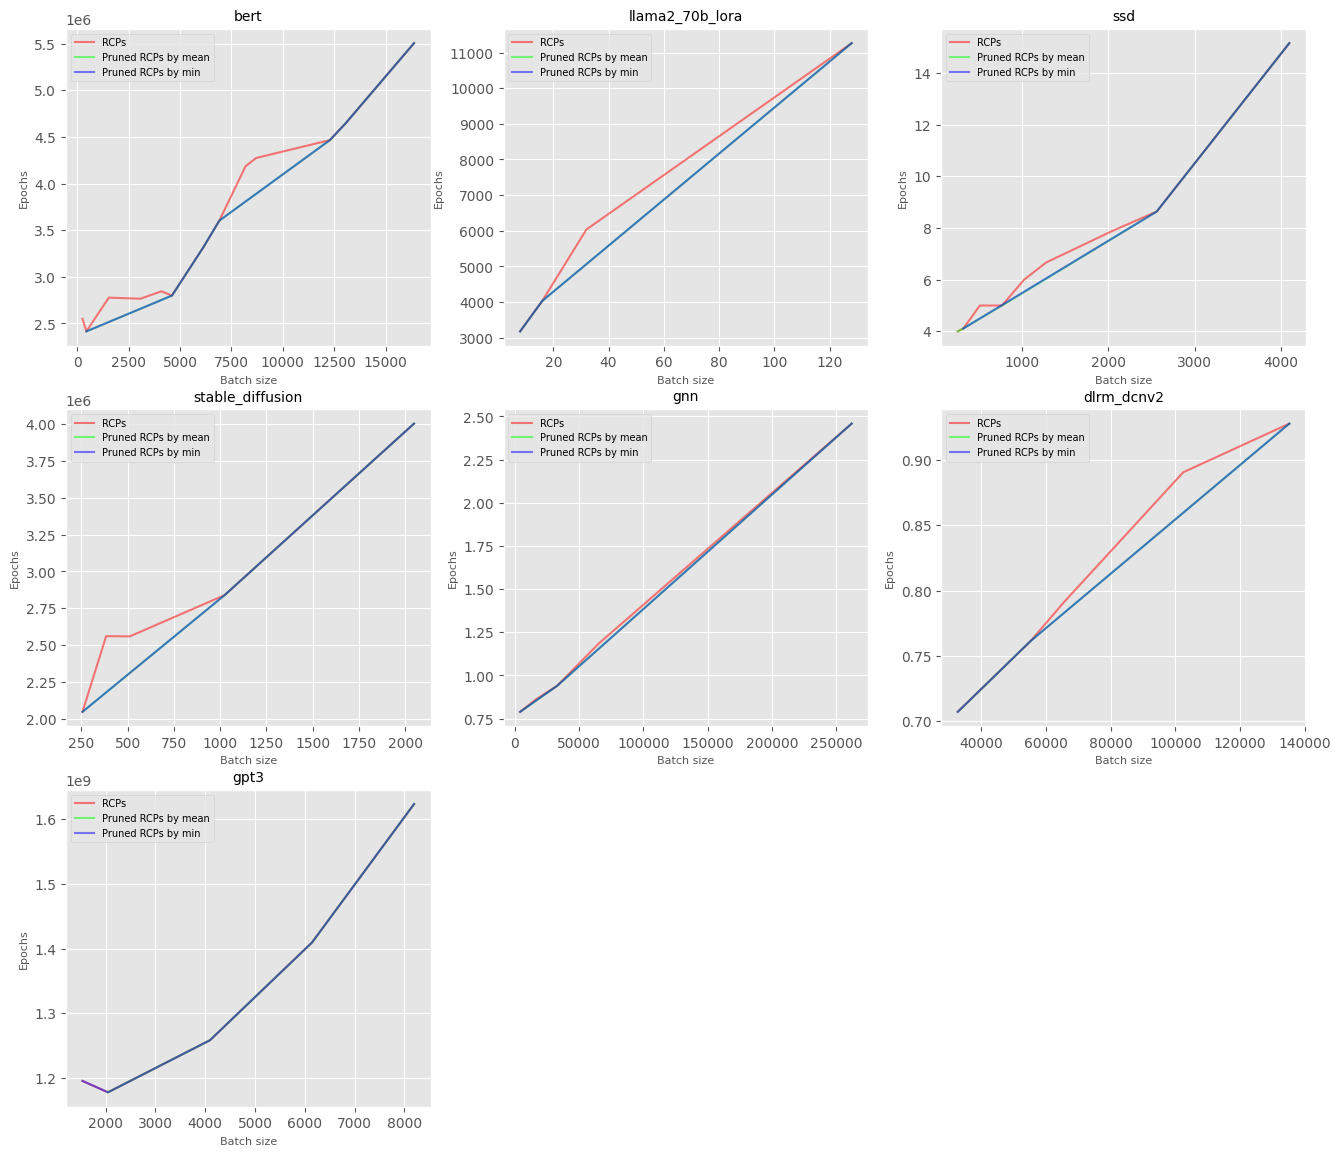

In [7]:
plt.figure(figsize=(16,14))
for i in range(len(benchmarks)):
    x1 = np.sort(batch_sizes[i])
    y1 = np.array(mean_epochs[i])[np.argsort(batch_sizes[i])]
    x2, y2 = prune_rcps_by_mean(batch_sizes[i], mean_epochs[i])
    x3, y3 = prune_rcps_by_min(batch_sizes[i], mean_epochs[i], min_epochs[i])
    plt.subplot(3, 3, i+1)
    plt.title(benchmarks[i], {"size": 10})
    plt.plot(x1, y1, label="RCPs", alpha=0.5, color='#FF0000')
    plt.plot(x2, y2, label="Pruned RCPs by mean", alpha=0.5, color='#00FF00')
    plt.plot(x3, y3, label="Pruned RCPs by min", alpha=0.5, color='#0000FF')
    plt.xlabel("Batch size", fontdict={'size': 8})
    plt.ylabel("Epochs", fontdict={'size': 8})
    plt.legend(prop={'size': 7})

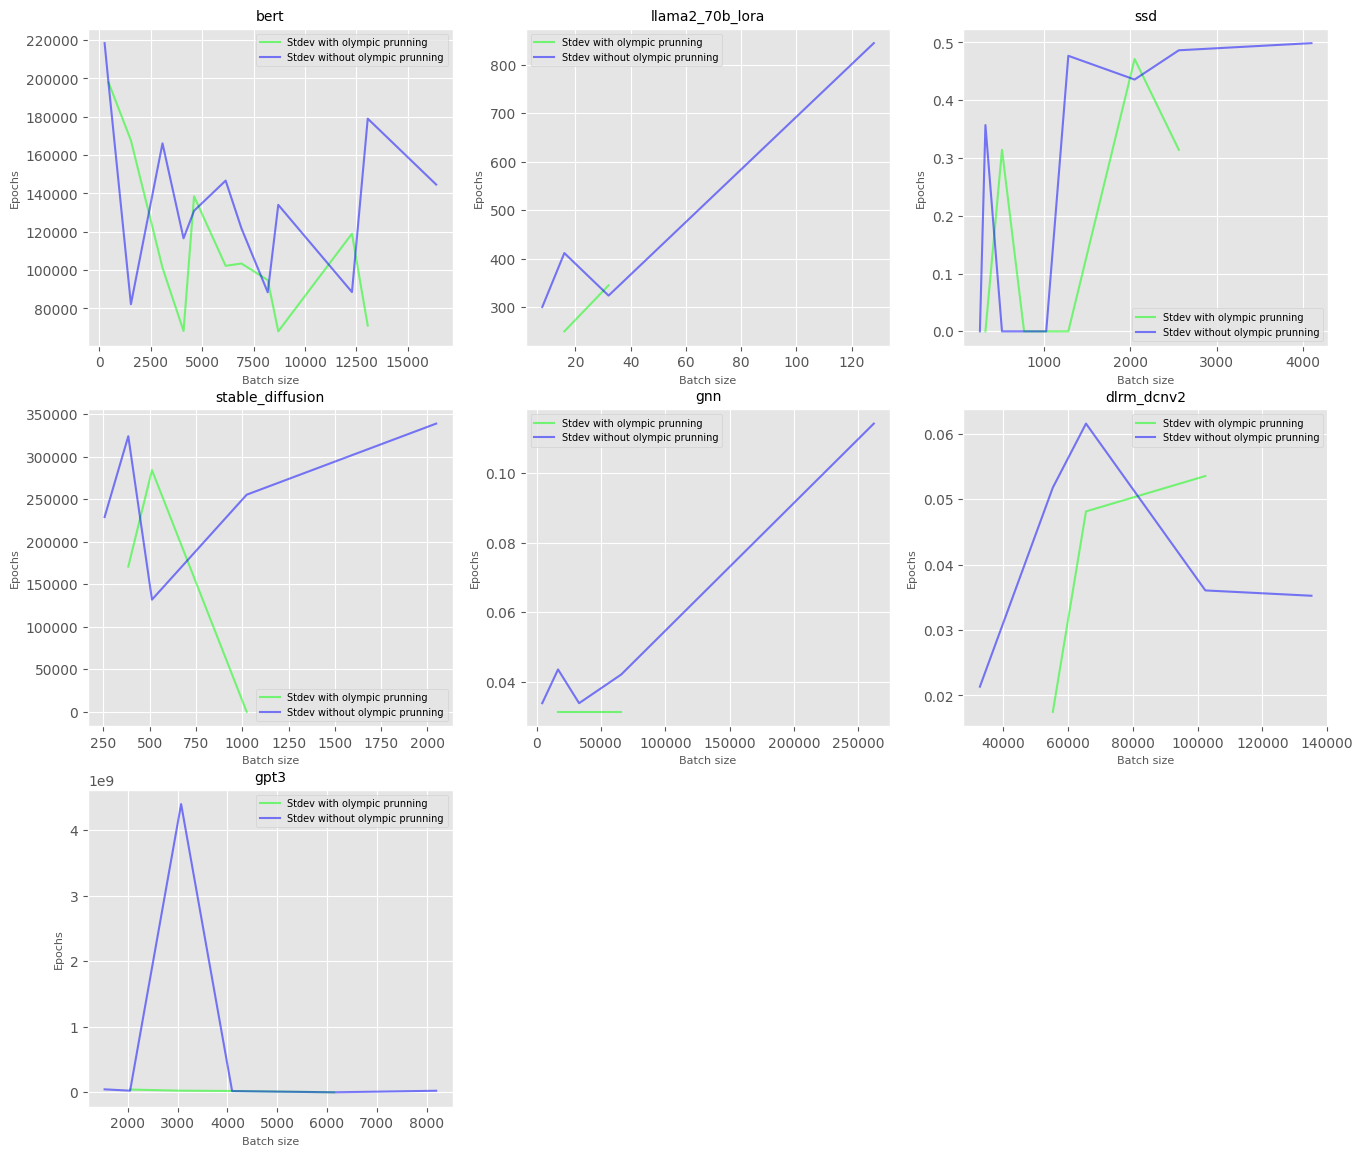

In [8]:
# Perform olympic prunning
for i in range(len(benchmarks)):
    batch_sizes[i] = batch_sizes[i][1:-1]

## SECOND PLOT
plt.figure(figsize=(16,14))
for i in range(len(benchmarks)):
    # x1 = np.sort(batch_sizes[i])
    # y1 = np.array(mean_epochs[i])[np.argsort(batch_sizes[i])]
    x2 = np.sort(batch_sizes[i])
    y2 = np.array(std_epochs[i])[np.argsort(batch_sizes[i])]
    x3 = np.sort(batch_sizes_[i])
    y3 = np.array(std_epochs_[i])[np.argsort(batch_sizes_[i])]
    plt.subplot(3, 3, i+1)
    plt.title(benchmarks[i], {"size": 10})
    plt.plot(x2, y2, label="Stdev with olympic prunning", alpha=0.5, color='#00FF00')
    plt.plot(x3, y3, label="Stdev without olympic prunning", alpha=0.5, color='#0000FF')
    plt.xlabel("Batch size", fontdict={'size': 8})
    plt.ylabel("Epochs", fontdict={'size': 8})
    plt.legend(prop={'size': 7})

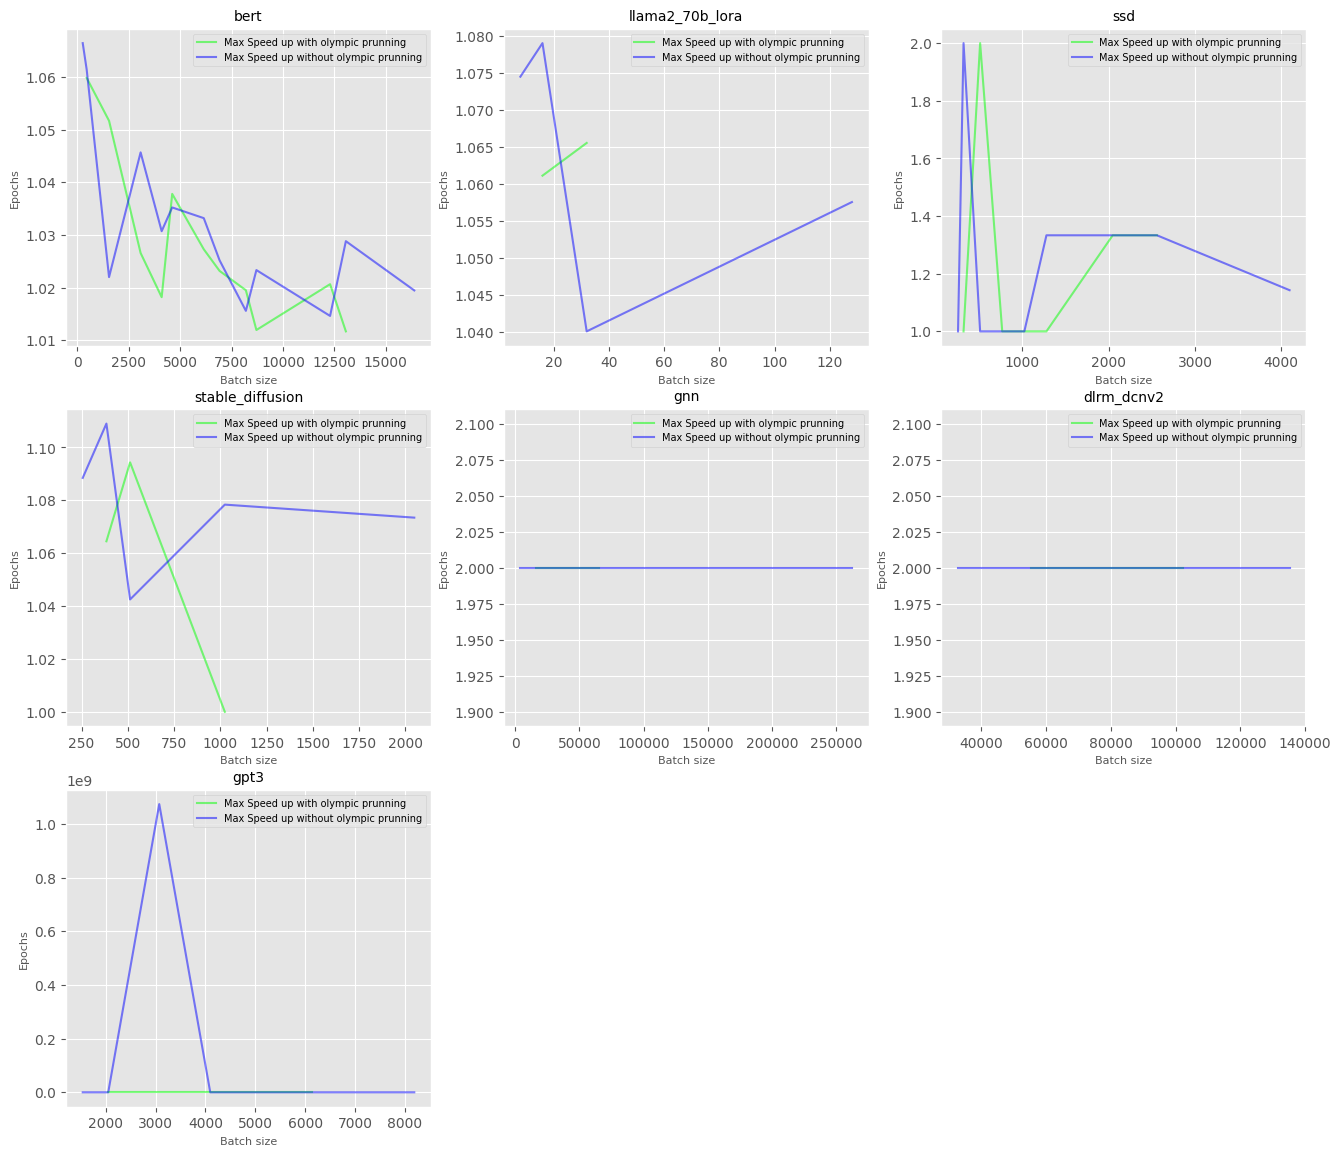

In [9]:
plt.figure(figsize=(16,14))
for i in range(len(benchmarks)):
    # x1 = np.sort(batch_sizes[i])
    # y1 = np.array(mean_epochs[i])[np.argsort(batch_sizes[i])]
    x2 = np.sort(batch_sizes[i])
    y2 = np.array(max_speed_up[i])[np.argsort(batch_sizes[i])]
    x3 = np.sort(batch_sizes_[i])
    y3 = np.array(max_speed_up_[i])[np.argsort(batch_sizes_[i])]
    plt.subplot(3, 3, i+1)
    plt.title(benchmarks[i], {"size": 10})
    # plt.plot(x1, y1, label="RCPs", alpha=0.5, color='#FF0000')
    plt.plot(x2, y2, label="Max Speed up with olympic prunning", alpha=0.5, color='#00FF00')
    plt.plot(x3, y3, label="Max Speed up without olympic prunning", alpha=0.5, color='#0000FF')
    plt.xlabel("Batch size", fontdict={'size': 8})
    plt.ylabel("Epochs", fontdict={'size': 8})
    plt.legend(prop={'size': 7})